In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 8.3MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 133kB 51.0MB/s 
     |████████████████████████████████| 7.6MB 50.0MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
ERROR: botocore 1.20.97 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import sys
import numpy as np
import random as rn
import pandas as pd

import codecs
import itertools
import seaborn as sns

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer,BertModel, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
from keras.preprocessing.sequence import pad_sequences

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

import io
import matplotlib.pyplot as plt



In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
rn.seed(501)
np.random.seed(501)
torch.manual_seed(501)
torch.cuda.manual_seed(501)

# max lengrh of a sentence, fed into the network
MAX_LEN = 150


**Load Dataset**

We'll use The semeval dataset for single sentence classification. It's a set of sentences labeled as offensive correct or not. The data is as follows:

Column 1: the id of the sentence

Column 2: the tweet text	

Column 3: Label : Sub-task A - Offensive language identification

Column 4: Label : Sub-task B - Automatic categorization of offense types

Column 5: Label : Sub-task C - Offense target identification.


In [ ]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving agr_hi_dev.csv to agr_hi_dev.csv
Saving agr_hi_fb_gold.csv to agr_hi_fb_gold.csv
Saving agr_hi_fb_test.csv to agr_hi_fb_test.csv
Saving agr_hi_sm_test.csv to agr_hi_sm_test.csv
Saving agr_hi_train.csv to agr_hi_train.csv
Saving agr_hi_tw_gold.csv to agr_hi_tw_gold.csv


In [ ]:
df_trac_train = pd.read_csv('agr_hi_train.csv', header=None)
df_trac_dev = pd.read_csv('agr_hi_dev.csv', header=None)
df_trac_fb_gold = pd.read_csv('agr_hi_fb_gold.csv', header=None)
df_trac_tw_gold = pd.read_csv('agr_hi_tw_gold.csv', header=None)
df_trac = pd.concat(
    [df_trac_train, df_trac_dev, df_trac_fb_gold, df_trac_tw_gold],
    ignore_index=True)

X_trac = df_trac[1].values
y_trac = df_trac[2].values


y_trac = np.array([
    s.replace('NAG', 'NOT').replace('OAG', 'OFF').replace('CAG', 'OFF')
    for s in y_trac
])


In [ ]:
trac_test = pd.read_csv('agr_hi_sm_test.csv', header=None)
trac_test1 = pd.read_csv('agr_hi_fb_test.csv', header=None)
df_tractest = pd.concat(
    [trac_test, trac_test1],
    ignore_index=True)
X_tractest_id = df_tractest[0].values
X_tractest = df_tractest[1].values

In [ ]:
z_trac = df_trac[0].values

In [ ]:
print (X_trac[:10])

['Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu 😂 1 hazar saal tjhy ghulam bana kr rkha tha bhol gaya tu'
 'Bhai 60sal pehle desh me kya tha pehle pta kro desh waise ka waise kaise hai'
 'chutiya friday ko isliye releae krte kyoki week end ke 3 din milte h to log free hokr film dekh sake..!! hd h yrr chutiyapa ki'
 'जय मोदीराज' 'UPA walo ne bahot kuch kr diya tha desh k liye'
 'Pan ko Aadhar se link ki zarurat kuy hai? Supreme Court ne ye bola hi nahi'
 'काकर पाथर जोड़ के मस्जिद लई बनाय।\n\nता चढ़ि मुल्ला बांघ दे , क्या बहरा हुआ खुदाय। \n\nयह मैं नहीं कबीर ने कहा था।'
 'Us raat tere papa k jageh mera sperm gya tha use of technology \nAur tere papa ko pta v na chala 😂😂😂\nChutiya'
 'गटर के कीड़े'
 'Waise bandhu jet lag se bachne ke liye Raat ko 10 baje ke baad so jao']


In [ ]:
type(X_trac)

numpy.ndarray

In [ ]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in X_trac]

In [ ]:
sentences[:10]

['[CLS] Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu 😂 1 hazar saal tjhy ghulam bana kr rkha tha bhol gaya tu [SEP]',
 '[CLS] Bhai 60sal pehle desh me kya tha pehle pta kro desh waise ka waise kaise hai [SEP]',
 '[CLS] chutiya friday ko isliye releae krte kyoki week end ke 3 din milte h to log free hokr film dekh sake..!! hd h yrr chutiyapa ki [SEP]',
 '[CLS] जय मोदीराज [SEP]',
 '[CLS] UPA walo ne bahot kuch kr diya tha desh k liye [SEP]',
 '[CLS] Pan ko Aadhar se link ki zarurat kuy hai? Supreme Court ne ye bola hi nahi [SEP]',
 '[CLS] काकर पाथर जोड़ के मस्जिद लई बनाय।\n\nता चढ़ि मुल्ला बांघ दे , क्या बहरा हुआ खुदाय। \n\nयह मैं नहीं कबीर ने कहा था। [SEP]',
 '[CLS] Us raat tere papa k jageh mera sperm gya tha use of technology \nAur tere papa ko pta v na chala 😂😂😂\nChutiya [SEP]',
 '[CLS] गटर के कीड़े [SEP]',
 '[CLS] Waise bandhu jet lag se bachne ke liye Raat ko 10 baje ke baad so jao [SEP]']

**Inputs**

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[1])

100%|██████████| 231508/231508 [00:00<00:00, 906497.68B/s]


Tokenize the first sentence:
['[CLS]', 'b', '##hai', '60s', '##al', 'pe', '##hl', '##e', 'des', '##h', 'me', 'ky', '##a', 'tha', 'pe', '##hl', '##e', 'pt', '##a', 'k', '##ro', 'des', '##h', 'wai', '##se', 'ka', 'wai', '##se', 'kai', '##se', 'hai', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

*   input ids: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary

*   segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence

*   attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)

*   labels: a single value of 1 or 0. In our task 1 means "offensive" and 0 means "not offensive"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) pad_sequences is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (862 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (644 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1747 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1055 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (704 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length

In [ ]:
# Pad our input tokens

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
def encode_label_bin(y, predicted_label):
    choose = lambda l : 1 if l == predicted_label else 0
    return [choose(l) for l in y]

In [ ]:
# Indexing Labels
y = encode_label_bin(y_trac, 'OFF')

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, y, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

**Train Model**

Now that our input data is properly formatted, it's time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We'll load BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

**Structure of Fine-Tuning Model** 

we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "offensive/non-offensive" that are then fed into cross-entropy loss.


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
#Memory release
y, x, pooled = None, None, None
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
 torch.cuda.empty_cache()
 str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 40735490.49B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

*   Batch size: 16, 32
*   Learning rate (Adam): 5e-5, 3e-5, 2e-5
*   Number of epochs: 2, 3, 4

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

**Training loop:**

Tell the model to compute gradients by setting the model in train mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress

**Evalution loop:**

Tell the model not to compute gradients by setting th emodel in evaluation mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

Y=[]
Z=[]
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    Y=Y+list(pred_flat)
    Z=Z+list(labels_flat)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.42650758350117607


Epoch:  33%|███▎      | 1/3 [08:53<17:46, 533.39s/it]

Validation Accuracy: 0.8526510141093474
Train loss: 0.3509963593960549


Epoch:  67%|██████▋   | 2/3 [17:48<08:53, 533.85s/it]

Validation Accuracy: 0.8604772927689595
Train loss: 0.28106887426466426


Epoch: 100%|██████████| 3/3 [26:43<00:00, 534.58s/it]

Validation Accuracy: 0.8602017195767195


In [ ]:
from sklearn.metrics import f1_score

print("F1: %.2f%%" % (f1_score(Y, Z, average='micro')*100))

F1: 85.81%


In [ ]:
print("F1: %.2f%%" % (f1_score(Y, Z, average='macro')*100))

F1: 72.89%


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("Accuracy: %.2f%%" % (accuracy_score(Y, Z)*100))
print("F1: %.2f%%" % (f1_score(Y, Z )*100))
print("Precission: %.2f%%" % (precision_score(Y, Z)*100))
print("Recall: %.2f%%" % (recall_score(Y, Z)*100))
print(classification_report(Y, Z))
print(confusion_matrix(Y, Z))

Accuracy: 85.81%
F1: 91.60%
Precission: 96.26%
Recall: 87.38%
              precision    recall  f1-score   support

           0       0.43      0.74      0.54       587
           1       0.96      0.87      0.92      4564

    accuracy                           0.86      5151
   macro avg       0.70      0.80      0.73      5151
weighted avg       0.90      0.86      0.87      5151

[[ 432  155]
 [ 576 3988]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.82046597 0.17953403]
 [0.16725726 0.83274274]]


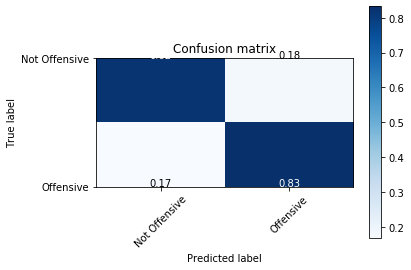

In [ ]:

cf_matrix = confusion_matrix(Y, Z)
plot_confusion_matrix(cf_matrix, ['Not Offensive', 'Offensive'], normalize=True)

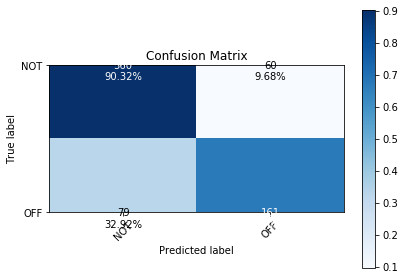

In [ ]:
from matplotlib.pyplot import *

# Final results

cm = np.array([[560,60], [79, 161]])


cmap=plt.cm.Blues
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.title('Confusion Matrix')
plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
plt.colorbar()
#cm = np.array([[560,60], [79, 161]])
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NOT', 'OFF'], rotation=45)
plt.yticks(tick_marks, ['NOT', 'OFF'])

# fmt = '.2f' if normalize else 'd'
fmt = '.2f'
thresh = 80
for i, j in itertools.product(range(2), range(2)):
    plt.text(j, i+0.1, str(cm[i, j]) + '\n' +str(format(cm_norm[i, j]*100, fmt)) + '%',
             horizontalalignment="center", multialignment='center',
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)
#fig.savefig('cm.png', dpi=400)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("Accuracy: %.2f%%" % (accuracy_score(Y, Z)*100))
print("F1: %.2f%%" % (f1_score(Y, Z)*100))
print("Precission: %.2f%%" % (precision_score(Y, Z)*100))
print("Recall: %.2f%%" % (recall_score(Y, Z)*100))
print(classification_report(Y, Z))
print(confusion_matrix(Y, Z))

Accuracy: 82.53%
F1: 78.89%
Precission: 74.94%
Recall: 83.27%
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2189
           1       0.75      0.83      0.79      1411

    accuracy                           0.83      3600
   macro avg       0.82      0.83      0.82      3600
weighted avg       0.83      0.83      0.83      3600

[[1796  393]
 [ 236 1175]]


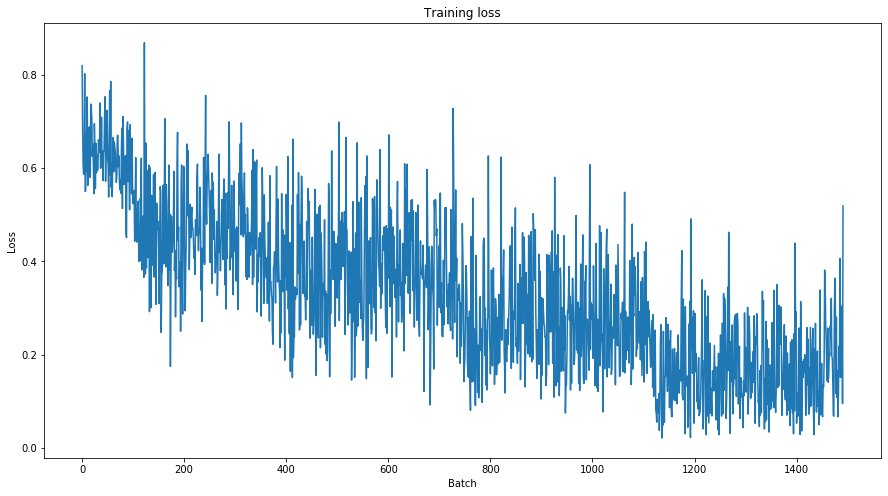

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/model")
#.state_dict()

In [ ]:
device = torch.device("cuda")
model1=torch.load('/content/model')
model1.to(device)

In [ ]:
torch.save(model.state_dict(), "/content/ha.h5")
#.state_dict()
device = torch.device("cuda")
model2=torch.load('/content/ha.h5')

In [ ]:
torch.save(model.state_dict(), "/content/model_state.pth")
#.state_dict()
from pytorch import Model
model3 = Model()
model3.load_state_dict(torch.load("/content/model_state.pth"))

In [ ]:
!ls

offenseval-training-v1.tsv  sample_data  testset-taska.tsv


In [ ]:
pwd

'/content'

In [ ]:

X_semeval1="@USER Or you are the wind between my cheeks!"
sentences1 = "[CLS] " + X_semeval1 + " [SEP]"

tokenized_texts1 = tokenizer.tokenize(sentences1)

input_ids1 = tokenizer.convert_tokens_to_ids(tokenized_texts1)
input_ids1=input_ids1+[0]*(150-13)
#input_ids1 = pad_sequences(input_ids1, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks1 = []

# Create a mask of 1s for each token followed by 0s for padding
attention_masks1= [float(i>0) for i in input_ids1]

"""
def encode_label_bin(y, predicted_label):
    choose = lambda l : 1 if l == predicted_label else 0
    return [choose(l) for l in y]

y = encode_label_bin(y_semeval, 'OFF')
"""

# Use train_test_split to split our data into train and validation sets for training


# Convert all of our data into torch tensors, the required datatype for our model

train_input1s = torch.tensor(input_ids1)

#train_labels1 = torch.tensor(train_labels1)

train_masks1 = torch.tensor(attention_masks1)


result=model(train_input1s,token_type_ids=None,attention_mask=train_masks1)

In [ ]:
train_masks1

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [ ]:
Ha=input_ids1+[0]*(150-13)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)